In [25]:
import pandas as pd
import numpy as np
import scipy.io
import os
import mat4py
import matplotlib.pyplot as plt
from tabula import read_pdf
import data_describe as dd

plt.rcParams["figure.figsize"] = (20, 10)

In [26]:
matlab_file_path = r'/Users/arivarasuperumal/Desktop/condition_monitoring/iot-condition-monitoring/data/N09_M07_F10_KI01_1.mat'

In [27]:
# Data Intake
def data_intake(matlab_file_path):
    
    """
    This function is to read the data from the matlab file and convert into dataframe for pre-processing
    
    Input - Matlab file
    
    Output - Uncleaned Dataframe resulted from reading the matlab file
    """

    data_dict = scipy.io.loadmat(matlab_file_path)
    data_array = data_dict[list(data_dict.keys())[3]]
    data = pd.DataFrame(data_array.flatten())
    
    return data
    

In [28]:
# Cleaning the dataframe and flattening the Columns for further analysis.

def data_flatten(data):
    
    """
    This function is to clean the dataframe and flatten the relevant columns for further Analysis
    
    Input - Resulted dataframe from reading the matlab file
    
    Output - Cleaned dataframe after flattening the values and filtering the relevant values from the dataframe 
    """
    
    for i in range(0,len(data.columns)):
        if (len(data[data.columns[i]][0].flatten()) == 0):
            continue
        elif (len(data[data.columns[i]][0].flatten()) == 1):
            data[data.columns[i]] = data[data.columns[i]].apply(lambda x: x.flatten()[0]) 
        elif (len(data[data.columns[i]][0].flatten()) > 1):
            data[data.columns[i]] = data[data.columns[i]].apply(lambda x: x.flatten()) 
            
    return data

In [29]:
# Merging the relevant data from the matlab files to form a holistic dataframe for further analysis.
def data_merge(data): 
    
    """
    This function is to merge the cleaned dataframe and form the consolidated dataframe for further analysis
    
    Input - Cleaned Dataframe after the processing the matlab file
            (Resulted dataframe from the data_flatten function) 
            
    Output - Merged final dataframe after removing the null columns  
    """
    
    data_x = pd.DataFrame(data['X'][0].flatten())
    data_x = data_flatten(data_x)

    data_y = pd.DataFrame(data['Y'][0].flatten())
    data_y = data_flatten(data_y)

    final = data_x[['Raster','Data']].merge(data_y[data_y.columns.difference(['Unit',
                                                                              'Description',
                                                                              'DisplayIdentifier']
                                                                              ,sort=False)]
                                            , on = 'Raster', how = 'left')
    
    return final

In [30]:
#Separating the main metrics and additional metrics into different tables for further analysis

def metrics(data):
    """
    This function is to create a new dataframe with the vibrations and current signals for further analysis
    
    Input - Merged final dataframe with the all relevant values from the matlab files
            (Resulted dataframe from the data_merge function) 
            
    Output -  Dataframe with vibrations and Current signals alone
    """
    
    metrics = pd.DataFrame(list(zip(data['Data_y'][3],
                                    data['Data_y'][4],
                                    data['Data_y'][5])),
                           columns = list(data['Name'][3:6]))
    
    return metrics

def add_metrics(data):
    
    """
    This function is to create a new dataframe with all supportive machine signals for further analysis
    
    Input - Merged final dataframe with the all relevant values from the matlab files
            (Resulted dataframe from the data_merge function) 
            
    Output -  Dataframe with all the additional mertrics for the further analysis
    """
    
    add_metric = pd.DataFrame(list(zip(data['Data_y'][0], 
                                       data['Data_y'][1],
                                       data['Data_y'][2])),
                              columns = list(final['Name'][0:3]))
    
    return add_metric

### Extracting Bearing Informations from pdf

In [31]:
pdf_file_path = r'/Users/arivarasuperumal/Desktop/condition_monitoring/iot-condition-monitoring/data/KA01.pdf'

In [32]:
file_pdf = read_pdf(pdf_file_path, pages = 'all', java_options="-Dfile.encoding=UTF8")

for i in range(0, len(file_pdf)):
    if i == 0:
        bearing_specs = file_pdf[0]
    elif i == 1:
        damage_specs = file_pdf[1] 

In [33]:
def bearing_specifications(bearing_specs):
    
    """
    This function is to clean the resulted dataframe from reading the pdf using tabula 
    and create a new dataframe for the specifications
    
    Input - Uncleaned Dataframe with the details about specifications of the bearing used in experiment,
    extracted from the first page of the pdf.
    
    Output - Dataframe with cleaned specifications and values.
    """
    
    temp = pd.DataFrame(index=bearing_specs.index, columns={'specification','value'})
    for i in range(0,len(bearing_specs)):
        if pd.isnull(bearing_specs['Category'][i]):
            temp['specification'][i] = bearing_specs['tion\rSpecification/Value'][i]
            temp['value'][i] = bearing_specs['Unnamed: 1'][i]        
        else:
            temp['specification'][i] = bearing_specs['Category'][i]
            temp['value'][i] = bearing_specs['Unit oper'][i] 

    temp = temp[(temp['specification'] != '-')].reset_index()
    del(temp['index'])
    
    return temp

### EDA using data-describe

In [34]:
# Creating DataFrame for the further Analysis

def eda_metrics_data(matlab_file_path):
    """
    This function is to create a dataframe for the EDA from reading the matlab files 
    using the above defined functions  
    
    Input -  Matlab file path 
    
    Output - Dataframe with vibratons and current signals for Analysis.
    
    """
    uncleaned_data = data_intake(matlab_file_path)
    cleaned_data = data_flatten(uncleaned_data)
    consolidated_cleaned_data = data_merge(cleaned_data)
    metrics_data = metrics(consolidated_cleaned_data)
    
    return metrics_data

In [35]:
metrics = eda_metrics_data(matlab_file_path)

In [36]:
# Summary of the data using data-describe package

dd.data_summary(metrics)

,Info
Rows,256001
Columns,3
Size in Memory,5.9 MB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
phase_current_1,float64,0,0,-3,-0,2.74,-0,1.65,7479,154
phase_current_2,float64,0,0,-3,-0,2.71,0.0018,1.66,7378,162
vibration_1,float64,0,0,-5,-0,5.63,-0,0.41,1930,2753


None

data-describe Summary Widget

<AxesSubplot:title={'center':'Correlation Matrix'}>

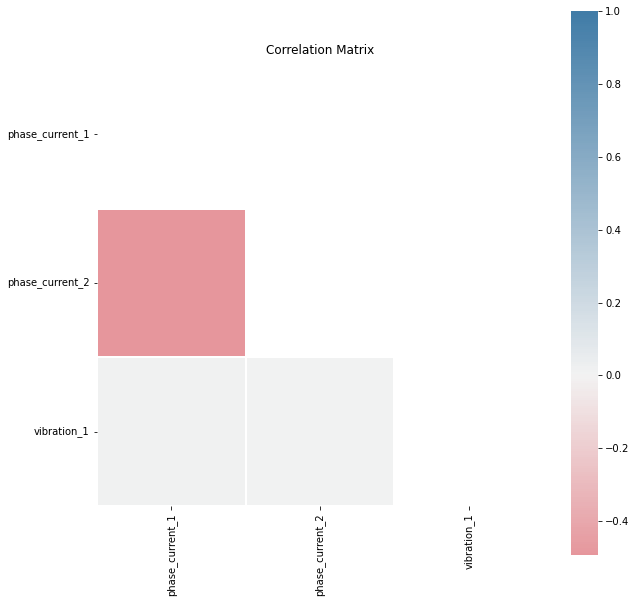

In [37]:
# Correlation matrix of the data using data-describe package

dd.correlation_matrix(metrics)

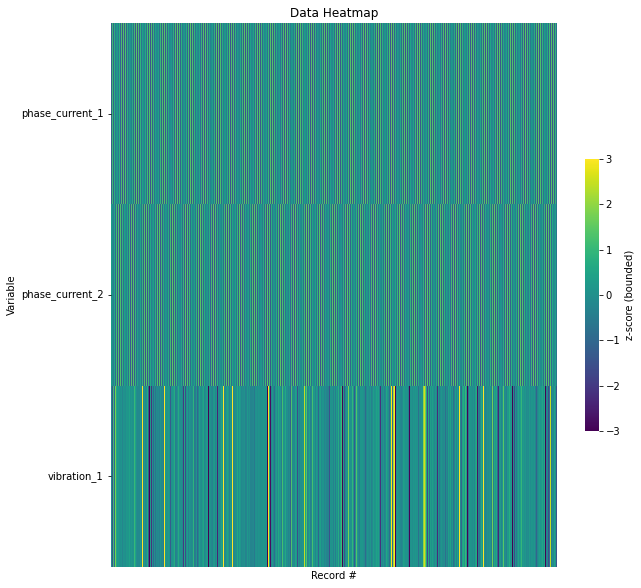

Heatmap Widget showing standardized values.

In [38]:
# Heatmap  

dd.data_heatmap(metrics)

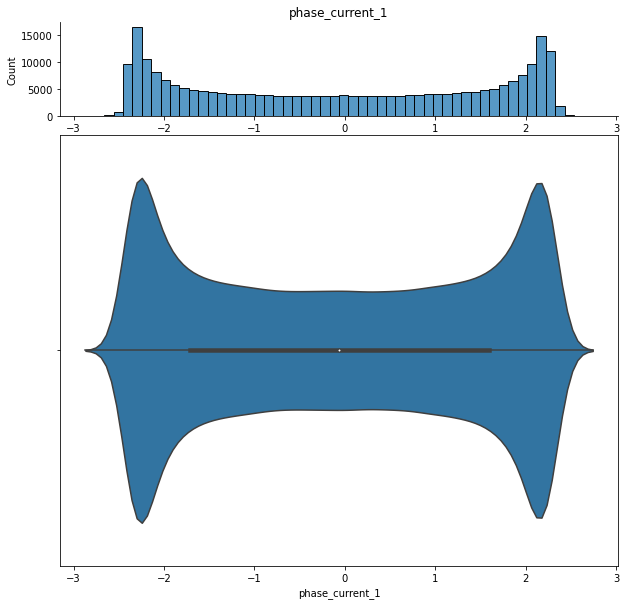

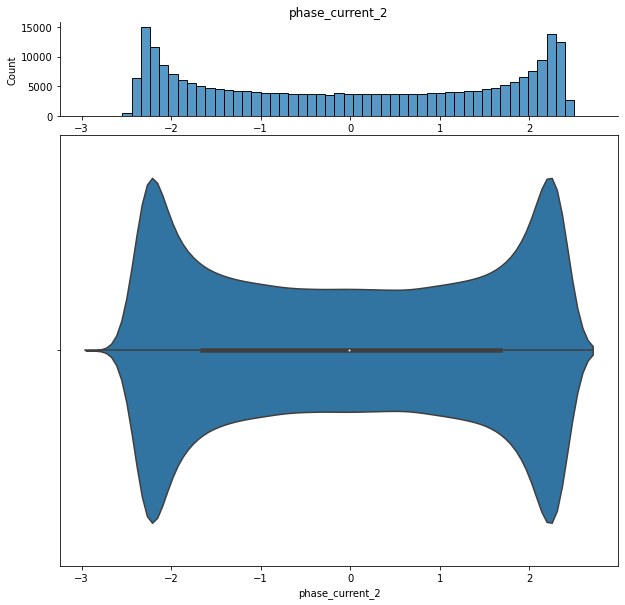

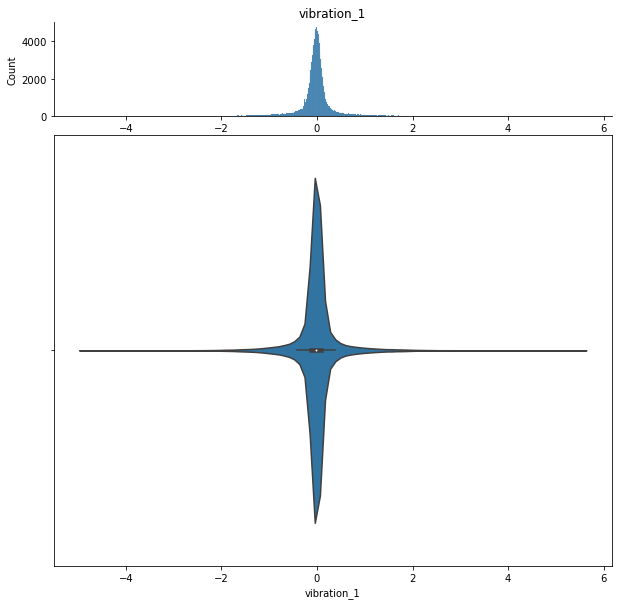

In [39]:
# Distribution of the experiment metrics

for col in metrics.columns:
    display(dd.distribution(metrics, plot_all=True).plot_distribution(col))

data-describe Scatter Plot Widget

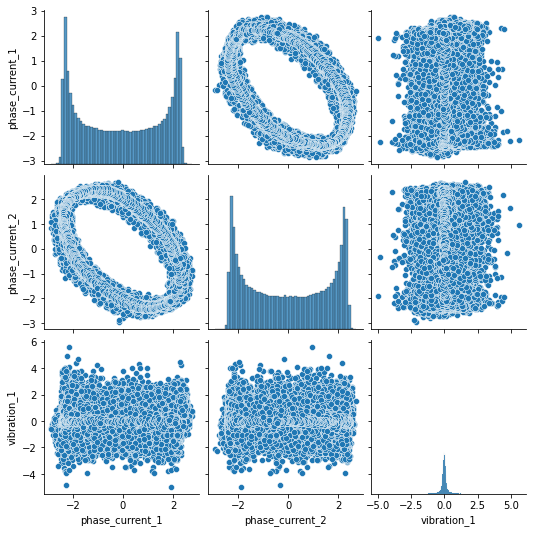

In [40]:
# Scatter plot of all variable

dd.scatter_plots(metrics, plot_mode='matrix')

### EDA - (Healthy vs IRD vs ORD)

In [41]:
healthy_matlab_file = r'/Users/arivarasuperumal/Desktop/condition_monitoring/iot-condition-monitoring/data/N09_M07_F10_K002_1.mat'
healthy_data  =  eda_metrics_data(healthy_matlab_file)

TypeError: 'DataFrame' object is not callable

In [ ]:
ird_matlab_file = r'/Users/arivarasuperumal/Desktop/condition_monitoring/iot-condition-monitoring/data/N09_M07_F10_KI01_1.mat'
ird_data  =  eda_metrics_data(ird_matlab_file)

In [ ]:
ord_matlab_file = r'/Users/arivarasuperumal/Desktop/condition_monitoring/iot-condition-monitoring/data/N09_M07_F10_KA01_1.mat'
ord_data  =  eda_metrics_data(ord_matlab_file)

In [ ]:
healthy_data = healthy_data.rename(columns = {'vibration_1':'healthy_vibrations'})
ird_data = ird_data.rename(columns = {'vibration_1':'ird_vibrations'})
ord_data = ord_data.rename(columns = {'vibration_1':'ord_vibrations'})